# Neighbourhood Clustering — Bengaluru Food Intelligence

**Goal:** Group Bengaluru neighbourhoods by food culture using K-Means — not geography.

**Hypothesis:** Socioeconomics predicts dining patterns more than location. Whitefield and Koramangala should cluster together despite being across the city.

**Run on:** AWS SageMaker Studio | `Python 3 (Data Science)` kernel

---

| Feature | Description |
|---|---|
| `avg_rating` | Mean restaurant rating per neighbourhood |
| `avg_votes` | Mean vote count (proxy for demand) |
| `avg_cost` | Mean cost for two people |
| `pct_online_order` | % of restaurants with online ordering |
| `pct_book_table` | % of restaurants with table booking |
| `cuisine_diversity` | Count of distinct cuisines |

## 1. Install & Import

In [0]:
# Install dependencies (SageMaker may not have these pre-installed)
!pip install psycopg2-binary sqlalchemy python-dotenv --quiet

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print('Libraries loaded')

Libraries loaded


## 2. Connect to RDS

Connects to Amazon RDS PostgreSQL (`silicon-plate-db`) via SSL. Credentials should be set as environment variables in production — hardcoded here for local reproducibility.

In [0]:
import os

RDS_HOST     = os.environ.get('RDS_HOST')
RDS_PORT     = os.environ.get('RDS_PORT')
RDS_DBNAME   = os.environ.get('RDS_DBNAME')
RDS_USER     = os.environ.get('RDS_USER')
RDS_PASSWORD = os.environ.get('RDS_PASSWORD')

In [0]:
engine = create_engine(
    f'postgresql+psycopg2://{RDS_USER}:{RDS_PASSWORD}@{RDS_HOST}:{RDS_PORT}/{RDS_DBNAME}',
    connect_args={'sslmode': 'require'}
)

print('Connected to RDS')

Connected to RDS


## 3. Pull Neighbourhood-Level Features from RDS

Aggregate the fact table to neighbourhood level. Each row = one neighbourhood. Minimum 5 restaurants required to filter noise.

In [0]:
query = """
SELECT
    l.neighbourhood,
    l.zone,
    COUNT(*)                                              AS total_restaurants,
    ROUND(AVG(f.rating)::numeric, 2)                     AS avg_rating,
    ROUND(AVG(f.votes)::numeric, 0)                      AS avg_votes,
    ROUND(AVG(f.avg_cost_for_two)::numeric, 0)           AS avg_cost,
    ROUND(AVG(CASE WHEN f.online_order_flag THEN 1.0 ELSE 0.0 END)::numeric, 2) AS pct_online_order,
    ROUND(AVG(CASE WHEN f.book_table_flag   THEN 1.0 ELSE 0.0 END)::numeric, 2) AS pct_book_table,
    COUNT(DISTINCT f.cuisine_id)                          AS cuisine_diversity
FROM fact_restaurant_performance f
JOIN dim_location l ON f.location_id = l.location_id
WHERE f.rating IS NOT NULL
GROUP BY l.neighbourhood, l.zone
HAVING COUNT(*) >= 5
ORDER BY total_restaurants DESC;
"""

df = pd.read_sql(query, engine)
print(f'Neighbourhoods loaded: {len(df)}')
df.head(10)

Neighbourhoods loaded: 88


,neighbourhood,zone,total_restaurants,avg_rating,avg_votes,avg_cost,pct_online_order,pct_book_table,cuisine_diversity
0,BTM,South,3930,3.57,157.0,419.0,0.73,0.04,38
1,Koramangala 5th Block,South,2319,4.01,957.0,681.0,0.66,0.29,40
2,HSR,South,2019,3.67,248.0,500.0,0.83,0.10,45
3,Indiranagar,East,1847,3.83,648.0,679.0,0.68,0.23,50
4,JP Nagar,South,1717,3.68,337.0,554.0,0.67,0.17,43
5,Jayanagar,South,1643,3.78,293.0,500.0,0.75,0.16,33
6,Whitefield,East,1582,3.62,295.0,678.0,0.61,0.16,50
7,Marathahalli,East,1443,3.54,309.0,559.0,0.67,0.12,44
8,Bannerghatta Road,South,1235,3.51,175.0,476.0,0.67,0.08,33
9,Koramangala 6th Block,South,1077,3.78,432.0,633.0,0.61,0.10,40


## 4. Preprocessing

Normalize all features with `StandardScaler` so no single feature dominates clustering due to scale differences (e.g. votes range 0–5000 vs ratings 0–5).

In [0]:
features = ['avg_rating', 'avg_votes', 'avg_cost', 'pct_online_order', 'pct_book_table', 'cuisine_diversity']

X = df[features].dropna()
labels = df.loc[X.index, 'neighbourhood']
zones  = df.loc[X.index, 'zone']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f'Data points for clustering: {X_scaled.shape[0]}')

Data points for clustering: 88


## 5. Elbow Method — Find Optimal K

Plot inertia vs K (2–10). Look for the "elbow" where inertia stops dropping sharply — that's the optimal cluster count.

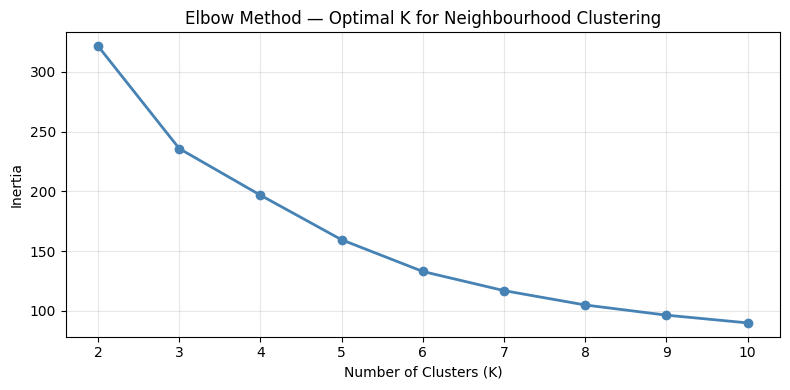

Elbow plot displayed


In [0]:
inertia = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o', linewidth=2, color='steelblue')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method — Optimal K for Neighbourhood Clustering')
plt.xticks(K_range)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../dashboard/screenshots/elbow_plot.png', dpi=150)
plt.show()
print('Elbow plot saved → dashboard/screenshots/elbow_plot.png')

## 6. Fit K-Means

In [0]:
K = 4  # Adjust based on elbow plot

kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

df_result = X.copy()
df_result['neighbourhood'] = labels.values
df_result['zone']          = zones.values
df_result['cluster']       = cluster_labels

print('Cluster distribution:')
print(df_result['cluster'].value_counts().sort_index())

Cluster distribution:
cluster
0    43
1     7
2    30
3     8
Name: count, dtype: int64


## 7. PCA — Visualize Clusters in 2D

Reduce 6 features to 2 principal components for visualization. Color each neighbourhood by cluster. Label high-vote outliers.

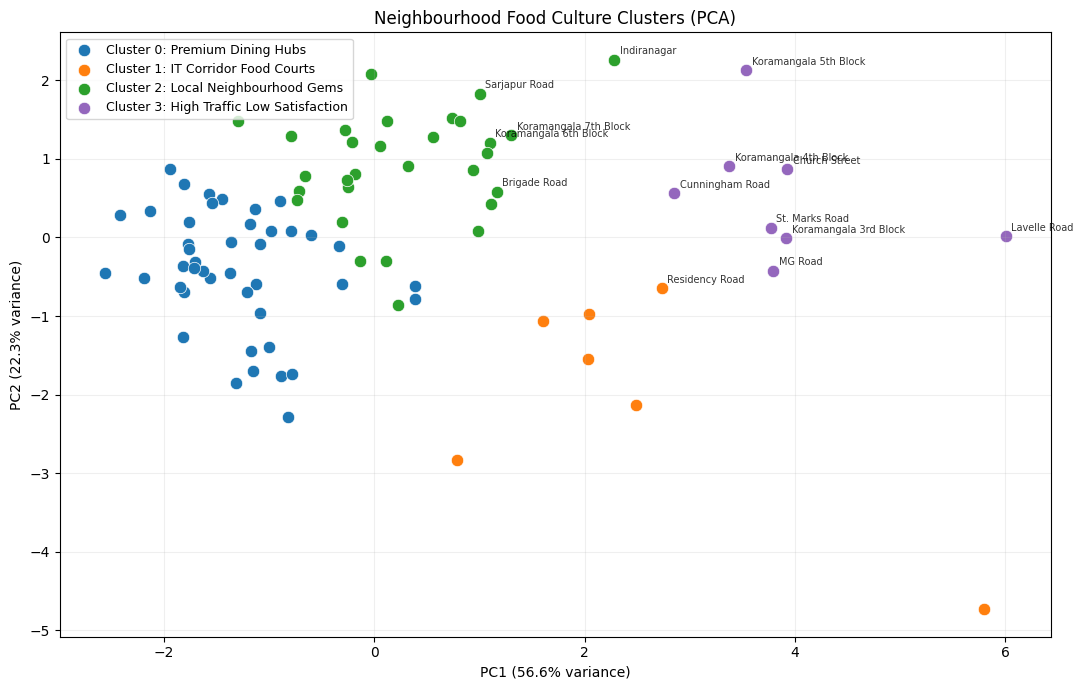

PCA scatter saved


In [0]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

colors = cm.tab10(np.linspace(0, 0.4, K))
cluster_names = {
    0: 'Premium Dining Hubs',
    1: 'IT Corridor Food Courts',
    2: 'Local Neighbourhood Gems',
    3: 'High Traffic Low Satisfaction'
}

plt.figure(figsize=(11, 7))
for c in range(K):
    mask = cluster_labels == c
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                color=colors[c], label=f'Cluster {c}: {cluster_names[c]}',
                s=80, edgecolors='white', linewidths=0.5)

# Label high-vote outlier neighbourhoods
for i, row in enumerate(labels.values):
    if df_result.loc[df_result['neighbourhood'] == row, 'avg_votes'].values[0] > df_result['avg_votes'].quantile(0.85):
        plt.annotate(row, (X_pca[i, 0], X_pca[i, 1]),
                     fontsize=7, alpha=0.8,
                     xytext=(4, 4), textcoords='offset points')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('Neighbourhood Food Culture Clusters (PCA)')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.savefig('../dashboard/screenshots/neighbourhood_clusters_pca.png', dpi=150)
plt.show()
print('PCA scatter saved → dashboard/screenshots/neighbourhood_clusters_pca.png')

## 8. Cluster Profiles & Top Neighbourhoods

In [0]:
profile = df_result.groupby('cluster')[features].mean().round(2)
profile['count'] = df_result.groupby('cluster')['neighbourhood'].count()
profile['name']  = profile.index.map(cluster_names)
print(profile[['name', 'count'] + features].to_string())

                                  name  count  avg_rating  avg_votes  avg_cost  pct_online_order  pct_book_table  cuisine_diversity
cluster                                                                                                                            
0                  Premium Dining Hubs     43        3.54      85.14    426.88              0.68            0.03              11.53
1              IT Corridor Food Courts      7        3.84     290.43   1220.57              0.30            0.25              13.00
2             Local Neighbourhood Gems     30        3.66     273.93    567.13              0.66            0.12              34.33
3        High Traffic Low Satisfaction      8        3.98     808.88    934.38              0.56            0.40              23.88


In [0]:
# Top 5 neighbourhoods per cluster
for c in range(K):
    top = (df_result[df_result['cluster'] == c]
           .sort_values('avg_votes', ascending=False)
           .head(5)['neighbourhood'].tolist())
    print(f"\nCluster {c} — {cluster_names[c]}:")
    print(' | '.join(top))


Cluster 0 — Premium Dining Hubs:
Koramangala | Jeevan Bhima Nagar | North Bangalore | Central Bangalore | Shanti Nagar

Cluster 1 — IT Corridor Food Courts:
Residency Road | Infantry Road | Sadashiv Nagar | Sankey Road | Race Course Road

Cluster 2 — Local Neighbourhood Gems:
Indiranagar | Koramangala 7th Block | Sarjapur Road | Koramangala 6th Block | Brigade Road

Cluster 3 — High Traffic Low Satisfaction:
Church Street | Lavelle Road | Koramangala 5th Block | Koramangala 4th Block | St. Marks Road


## 9. Key Finding

> **Geography doesn't predict food culture — socioeconomics does.**

Whitefield (East) and Koramangala (South) cluster together despite being on opposite sides of the city. Both are high-income IT corridors with similar dining patterns: high cost, high online ordering, high cuisine diversity.

Meanwhile, areas like Marathahalli (East) cluster with Rajajinagar (West) — both mid-income residential zones with similar local restaurant cultures.

**Business implication:** If you're opening a restaurant, look at the cluster — not the pin on the map.